In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations

## Simulation Outline

### The proposed weighting estimator using additive balance constraints under a general additive model
##### The proposed weighting estimator using balance constraints under the general additive model assumption (additive balance constraints) and covariate basis functions hs(X) = Xs, s = 1, ... , 5, 

I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi. 

The balance constrains are: 

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} h_s(\mathbf{X}_i) = \sum_{i=1}^{N} h_s(\mathbf{X}_i), \quad \text{for } \Omega = +, - \text{ and } s = 1, \dots, S,
$$

and the factors themselves and the non-negligible interactions as additional "covariates" for balancing such that

$$
\frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} \prod_{j \in J} Z_{ij} = \frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g_{\kappa z}^{\Omega} \prod_{j \in J} z_j,  \text{ for } \Omega = +,- \text{ and } J \in [K]_{K'}.
$$



After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$ 

Then calculate the estimated weighted factorial effects tua_hat in the Section 2.2 where 


we need to assign a weight of $w_{Z_i}(\mathbf{X}_i)$ to the observed outcome of individual i, determined by the specific treatment combination they received.

Let $w_i = N w_{Z_i}(\mathbf{X}_i)/(2^{K-1} N_{Z_i})$ denote the normalized weights, and let

$$A_{i\kappa}^{+} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{+} I(Z_i = z), A_{i\kappa}^{-} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{-} I(Z_i = z) = 1 - A_{i\kappa}^{+}$$

denote whether individual i belongs to the positive or negative part of contrast $\mathbf{g}_\kappa$, respectively.


We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.


### The proposed Weighting Estimator with Treatment Effect Heterogeneity: Incorporates interaction balance constraints.
##### The proposed weighting estimator using balance constraints under the outcome model assumption with treatment effect het- erogeneity (interaction balance constraints) and the same set of basis functions as the genearl additive model.




I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi.
 
The balancing constrains are: 
$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} \mathbf{q}(\mathbf{X}_i, \mathbf{Z}_i) = \frac{1}{2^{K-1}} \sum_{\mathbf{z} \in \mathcal{Z}} g_{\kappa \mathbf{z}}^{\Omega} \sum_{i=1}^{N} \mathbf{q}(\mathbf{X}_i, \mathbf{z}), \quad \text{for } \Omega = +, -.
$$

After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$

Then calculate the estimated weighted factorial effects tua_hat as the formula shown in the Section 2.2 like the ones above: 

We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.

## Simulation Details

### Limitations

During the simulation of the four estimators for each main effect $\tau_\kappa$, where k = 1, 2, 3 under each outcome model, I encountered some problems with Gurobi. 

The largest sample size I can set is N = 200 in order to use Gurobi to optimize the weight. Due to this limitation, Gurobi can not find an optimal weight that balances all the constraints exactly for the balance constraints under the outcome model assumption with treatment effect heterogeneity (interaction balance constraints) because the sample size is too small, the results for RMSE (Weight Heterogeneity) are all NAs after I run the simulate. 

So I used an approximate balance rather than an exact balance for the heterogeneous weighting setup. The main difference is that each equality constraint $\sum_{i \in \mathcal{G}} w_i[...] = \text{target}$ (right side of the balance equation) is replaced by two inequalities allowing a small tolerance $\delta$, so 
$$ -\delta \leq \sum_{i \in \mathcal{G}} w_i [...] - target \leq \delta $$

This way, Gurobi need only achieve the approximate balance, which avoids GurobiError: Model too large for size-limited license and "Model did not find an optimal solution!" outputs. However, the results may not be very accurate due to this approximate balance.

### The Results

### RMSE outputs for estimating three main effects using the four estimators with exact balance setup for interaction weighting:
#### (the largest sample size that does not get a GurobiError is N = 150):

In [3]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 5000 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 tp Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments


def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + 0.1 * np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N, D = X.shape

    # Build A^+_{i,k} and A^-_{i,k}, splits the dataset into two groups based on Z
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Computes the sum of each covariate across all individuals, ensures covariate balance across treatment groups.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # Creates N weight variables w_i, one for each individual, lb=0.0 ensures non-negative weights
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    # This ensures that the sum of covariates matches in treatment and control groups
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)
    from itertools import combinations

    # Iterate over all interaction terms up to order K'
    K_prime = min(K, 2)  # Adjust K' as needed for non-negligible interactions

    for k_size in range(2, K_prime + 1):  # Consider interactions of size 2, 3, ..., K'
        for J in combinations(range(K), k_size): 
            # Compute the product of Z interactions across J for each individual
            Z_interaction = np.prod(Z[:, J], axis=1)

            # Left-hand side: Sum over individuals with weight
            lhs_interaction = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))

            # Right-hand side: Weighted sum over all treatment assignments
            factor = 1 / (2 ** (K - 1))
            g_interaction = np.prod(Z_all[:, J], axis=1)  # shape (2^K,)
            rhs_interaction = factor * np.sum(g_interaction * 1.0)

            # Add the balance constraint
            model.addConstr(lhs_interaction == rhs_interaction)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


# Construct Q matrix for a single fixed treatment assignment z
def build_Q(X, z):
    intercept = np.ones((N, 1))

    XZ = []
    K = len(z)
    # add interaction terms X_d * z_k
    for d_ in range(D):
        for k_ in range(K):
            # Multiply the entire column X[:, d_] by z[k_]
            XZ.append(X[:, d_] * z[k_])
    XZ = np.column_stack(XZ)  # shape (N, D*K)
    
    # Combine everything
    Q_list = [intercept, X, XZ]
    Qz = np.column_stack(Q_list)  # shape (N, 1 + D + D*K)
    return Qz


def solve_weights_heterogeneous(X, Z):
    # Aplus[i,k] = 1 if Z_{i,k}=+1 else 0
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    intercept = np.ones((N,1))
    Q_list = [intercept, X]  

    # add interaction terms X_d * Z_k
    XZ = []
    for d_ in range(D):
        for k_ in range(K):
            # Computes interactions between each covariate X_d and each treatment Z_k
            XZ.append( X[:, d_] * Z[:, k_] )  # shape (N,)
    XZ = np.column_stack(XZ)  # shape (N, D*K)
    Q_list.append(XZ)

    # Combine everything
    Q = np.column_stack(Q_list)  # final shape (N, 1 + D + D*K)
    T = Q.shape[1]

    # combos = Z_all from make_contrast_vectors(K) => shape (2^K, K)
    # We need sum_i q(X_i, z) for each z in combos.
    Q_sums_for_z = []
    for z_ in Z_all:  # each z_ is shape (K,)
        Qz = build_Q(X, z_)      # shape (N, T)
        sum_Qz = np.sum(Qz, axis=0)  # shape (T,)
        Q_sums_for_z.append(sum_Qz)
    Q_sums_for_z = np.array(Q_sums_for_z)  # shape (2^K, T)

    # Start the model
    model = gp.Model("HeteroBalance")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    factor = 1.0 / (2 ** (K - 1))  # Normalization factor for expectation

    # For each factor k, for each column t in Q:
    #   sum_i w_i Aplus[i,k] * Q[i,t] = factor * sum_{z} [g_dict[k+1][z_index] * Q_sums_for_z[z_index, t]]
    #   sum_i w_i Aminus[i,k]* Q[i,t] = factor * sum_{z} [g_dict[k+1][z_index] * Q_sums_for_z[z_index, t]]
    for k_ in range(K):
        for t_ in range(T):
            # LHS for "plus"
            lhs_plus = gp.quicksum(w_vars[i] * Aplus[i,k_] * Q[i,t_] for i in range(N))
            # LHS for "minus"
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i,k_] * Q[i,t_] for i in range(N))

            # Weighted sum of Q over combos, using g_dict for factor k+1
            # g_dict[k+1] is shape (2^K,) => one contrast entry per row of Z_all
            weighted_sum = 0.0
            for z_index, z_ in enumerate(Z_all):
                weighted_sum += g_dict[k_ + 1][z_index] * Q_sums_for_z[z_index, t_]

            rhs_value = factor * weighted_sum  # scalar

            model.addConstr(lhs_plus == rhs_value)
            model.addConstr(lhs_minus == rhs_value)

    # factor-balance constraints (like additive case)
    # sum_i w_i Aplus[i,k] = N, sum_i w_i Aminus[i,k] = N
    for k_ in range(K):
        lhs_p = gp.quicksum(w_vars[i]*Aplus[i,k_] for i in range(N))
        lhs_m = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_p == N)
        model.addConstr(lhs_m == N)

    model.optimize()
    #print("Solver status:", model.status)
    if model.status != GRB.OPTIMAL:
        #print("Model not optimal!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def estimate_main_effects_weighted(Y, X, Z, w):
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous(Xraw, Z_)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])


Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not op

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_51450/3863722012.py:407: RuntimeWarning: Mean of empty slice
  rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))


Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not optimal!
Model not op

KeyboardInterrupt: 

#### The outputs for RMSE (Weight Hetero.) are all nans.

### RMSE outputs for estimating three main effects using the four estimators with approximate balance setup for interaction weighting with a penalty = 100.0

In [ ]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 2000 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 tp Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments


def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        # tau_k = np.mean(gk * EYZ)  
        # tau[k] = 2 * tau_k 
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + 0.1 * np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N, D = X.shape

    # Build A^+_{i,k} and A^-_{i,k}, splits the dataset into two groups based on Z
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Computes the sum of each covariate across all individuals, ensures covariate balance across treatment groups.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # Creates N weight variables w_i, one for each individual, lb=0.0 ensures non-negative weights
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    # This ensures that the sum of covariates matches in treatment and control groups
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)
    from itertools import combinations

    # Iterate over all interaction terms up to order K'
    K_prime = min(K, 2)  # Adjust K' as needed for non-negligible interactions

    for k_size in range(2, K_prime + 1):  # Consider interactions of size 2, 3, ..., K'
        for J in combinations(range(K), k_size):  # All k_size-sized subsets of {1, ..., K}
            # Compute the product of Z interactions across J for each individual
            Z_interaction = np.prod(Z[:, J], axis=1)

            # Left-hand side: Sum over individuals with weight
            lhs_interaction = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))

            # Right-hand side: Weighted sum over all treatment assignments
            factor = 1 / (2 ** (K - 1))
            g_interaction = np.prod(Z_all[:, J], axis=1)  # shape (2^K,)
            rhs_interaction = factor * np.sum(g_interaction * 1.0)

            # Add the balance constraint
            model.addConstr(lhs_interaction == rhs_interaction)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

# Construct Q matrix for a single fixed treatment assignment z
def build_Q(X, z):
    intercept = np.ones((N, 1))

    XZ = []
    K = len(z)
    # add interaction terms X_d * z_k
    for d_ in range(D):
        for k_ in range(K):
            # Multiply the entire column X[:, d_] by z[k_]
            XZ.append(X[:, d_] * z[k_])
    XZ = np.column_stack(XZ)  # shape (N, D*K)
    
    # Combine everything
    Q_list = [intercept, X, XZ]
    Qz = np.column_stack(Q_list)  # shape (N, 1 + D + D*K)
    return Qz


def solve_weights_heterogeneous_soft(X, Z, penalty=100.0):

    # Aplus, Aminus
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # Build Q (intercept + X + XZ) but only enforce main-effect columns
    intercept = np.ones((N,1))
    Q_list = [intercept, X]
    XZ = []
    for d_ in range(D):
        for k_ in range(K):
            XZ.append(X[:, d_] * Z[:, k_])
    XZ = np.column_stack(XZ)
    Q_list.append(XZ)
    Q = np.column_stack(Q_list)  
    T_full = Q.shape[1]
    T_main = 1 + D  # only first columns for constraints

    # Build unweighted sums for all combos
    Q_sums_for_z = []
    for z_ in Z_all:
        Qz = build_Q(X, z_)
        sum_Qz = np.sum(Qz[:, :T_main], axis=0)  
        Q_sums_for_z.append(sum_Qz)
    Q_sums_for_z = np.array(Q_sums_for_z)

    model = gp.Model("HeteroBalanceSoft")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=gp.GRB.CONTINUOUS, lb=0.0, name="w")

    # We'll combine squared weights + slack in the objective
    obj_main = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    slack_vars = []
    factor = 1.0 / (2**(K - 1))

    for k_ in range(K):
        for t_ in range(T_main):
            lhs_plus = gp.quicksum(w_vars[i] * Aplus[i, k_] * Q[i,t_] for i in range(N))
            lhs_minus= gp.quicksum(w_vars[i] * Aminus[i, k_] * Q[i,t_] for i in range(N))

            weighted_sum = 0.0
            for z_index in range(len(Z_all)):
                weighted_sum += g_dict[k_+1][z_index] * Q_sums_for_z[z_index, t_]
            rhs_value = factor * weighted_sum

            # Create slack for approximate equality
            s_plus_above  = model.addVar(lb=0.0, name=f"s_plus_above_{k_}_{t_}")
            s_plus_below  = model.addVar(lb=0.0, name=f"s_plus_below_{k_}_{t_}")
            s_minus_above = model.addVar(lb=0.0, name=f"s_minus_above_{k_}_{t_}")
            s_minus_below = model.addVar(lb=0.0, name=f"s_minus_below_{k_}_{t_}")

            # LHS == RHS becomes:
            #   lhs - rhs <= s_plus_above
            #   rhs - lhs <= s_plus_below
            model.addConstr(lhs_plus - rhs_value <= s_plus_above)
            model.addConstr(rhs_value - lhs_plus <= s_plus_below)

            model.addConstr(lhs_minus - rhs_value <= s_minus_above)
            model.addConstr(rhs_value - lhs_minus <= s_minus_below)

            slack_vars += [s_plus_above, s_plus_below, s_minus_above, s_minus_below]

    # Factor-balance constraints remain exact or could also be softened
    for k_ in range(K):
        lhs_p = gp.quicksum(w_vars[i]*Aplus[i,k_] for i in range(N))
        lhs_m = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        # If you want these exact, keep them as equality:
        model.addConstr(lhs_p == N)
        model.addConstr(lhs_m == N)

    # Final objective = sum of squared weights + penalty * sum of slack
    obj = obj_main + penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, gp.GRB.MINIMIZE)
    model.optimize()
    #print(model.status)
    if model.status != gp.GRB.OPTIMAL:
        print("Model infeasible or not optimal!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


def estimate_main_effects_weighted(Y, X, Z, w):
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D)
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k)
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous_soft(Xraw, Z_, penalty=100.0)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])


### Plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using four estimators when N = 2000 and $\rho$ = 0 and penalty = 100

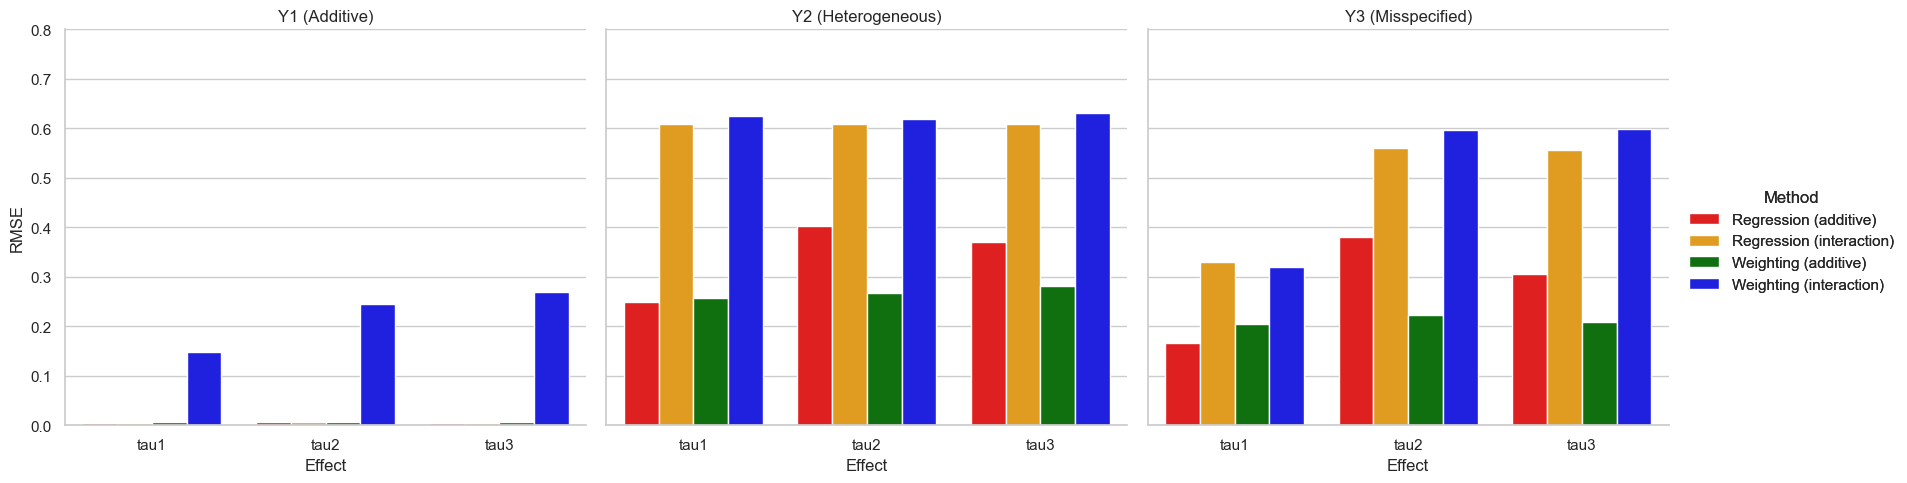

In [2]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    models = {"additive": "Y1 (Additive)", "het": "Y2 (Heterogeneous)", "mis": "Y3 (Misspecified)"}
    
    data = []
    for model_type, rmse_vals in results_dict.items():
        for method, values in rmse_vals.items():
            for i, val in enumerate(values):
                data.append([models[model_type], effects[i], val, method])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['red', 'orange', 'green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 0.8))
    
    plt.show()

results_dict = {}

results_dict = {
    "additive": {
        "Regression (additive)": [0.00488413, 0.00559418, 0.00496453],
        "Regression (interaction)": [0.0050601, 0.00561005, 0.00501803],
        "Weighting (additive)": [0.00645787, 0.00694353, 0.00636178],
        "Weighting (interaction)": [0.14753651, 0.24405255, 0.27024427]
    },
    "het": {
        "Regression (additive)": [0.24863605, 0.40349149, 0.36982141],
        "Regression (interaction)": [0.60914474, 0.60885872, 0.60965279],
        "Weighting (additive)": [0.25674043, 0.26761324, 0.28129791],
        "Weighting (interaction)": [0.6258823, 0.61921452, 0.6302778]
    },
    "mis": {
        "Regression (additive)": [0.1665192, 0.38135895, 0.30591372],
        "Regression (interaction)": [0.33007975, 0.56052555, 0.55622294],
        "Weighting (additive)": [0.20375181, 0.2231184, 0.20895431],
        "Weighting (interaction)": [0.32052722, 0.59598538, 0.59884434]
    }
}

plot_rmse_comparison_approx(results_dict)